**Lab 12 Representation learning**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/12_Representation_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/12_Representation_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# 🛠️ Setup

In [1]:
# @title Install packages
%pip install diffusers -qq
%pip install transformers ftfy accelerate -qq
%pip install torchinfo -qq
%pip install opentsne -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 73.8 MB/s eta 0:00:00


In [79]:
# @title Import packages
# Python ≥3.7 is recommended
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥1.01 is recommended
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Tensorflow ≥2.8.0 is recommended
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")

# Difussion model
import keras
print(tf.__version__, tf.keras.__version__, keras.__version__)

import torch
from torch import autocast
from tqdm.auto import tqdm
from torchinfo import summary
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler, PNDMScheduler

# Image related
from PIL import Image
from skimage.io import imread, imshow, show
from skimage.color import rgba2rgb
from skimage.transform import resize

# Common imports
from sklearn.decomposition import PCA
from openTSNE import TSNE
from scipy.spatial.transform import Rotation
import requests
import shutil
import numpy as np
import os
from pathlib import Path
import time

# To plot pretty figures
import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objects as go


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


# Visualize 2d manifold from  encodings using tSNE

def plot_embeddings_tsne(X_data, y_data, encodings):
  np.random.seed(42)
  tsne = TSNE(negative_gradient_method="fft")
  X_data_2D = tsne.fit(encodings)
  X_data_2D = (X_data_2D - X_data_2D.min()) / (X_data_2D.max() - X_data_2D.min())

  # adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
  plt.figure(figsize=(10, 8))
  cmap = plt.cm.tab10
  plt.scatter(X_data_2D[:, 0], X_data_2D[:, 1], c=y_data, s=10, cmap=cmap)
  image_positions = np.array([[1., 1.]])
  for index, position in enumerate(X_data_2D):
      dist = np.sum((position - image_positions) ** 2, axis=1)
      if np.min(dist) > 0.02: # if far enough from other images
          image_positions = np.r_[image_positions, [position]]
          imagebox = matplotlib.offsetbox.AnnotationBbox(
              matplotlib.offsetbox.OffsetImage(X_data[index], cmap="binary"),
              position, bboxprops={"edgecolor": cmap(y_data[index]), "lw": 2})
          plt.gca().add_artist(imagebox)
  plt.axis("off");

def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

# To visualize statistics of the hidden units adapted from https://github.com/probml/pyprobml/blob/master/notebooks/book1/20/ae_mnist_tf.ipynb

def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

def plot_activations_histogram2(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, ax1 = plt.subplots()
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plt.show()

    fig, ax2 = plt.subplots()
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])
    plt.show()

def plot_activations_heatmap(encoder, N=100):
    X = encoder(X_valid).numpy()
    plt.figure(figsize=(10,5))
    plt.imshow(X[:N,:])
    plt.colorbar()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def download_from_pokemondb(input_url, out_file):
  r = requests.get(input_url, stream=True)
  if r.status_code == 200:
    with open(out_file, 'wb') as f:
        r.raw.decode_content = True
        shutil.copyfileobj(r.raw, f)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

2.17.1 3.5.0 3.5.0


# 📘 Autoencoder

## PCA with a linear Autoencoder

If the autoencoder uses only linear activations and the cost function is the mean squared error (MSE), then it ends up performing Principal Component Analysis. The following code builds a simple linear autoencoder to perform PCA on a 3D dataset, projecting it to 2D

In [3]:
# @title Generate 3D data
m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

fig = go.Figure(data=[go.Scatter3d(
    x=X_train[:, 0],
    y=X_train[:, 1],
    z=X_train[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color='black',
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title="x1",
        yaxis_title="x2",
        zaxis_title="x3"
    ),
    width=600,
    height=380,
    margin=dict(r=20, l=10, b=10, t=10)
)

fig.show()

If the autoencoder uses only linear activations and the cost function is the  mean squared error (MSE), then it ends up performing principal component analysis:

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # Ensures reproducibility on CPU

encoder_input = tf.keras.Input(shape=[3])
encoder_output = tf.keras.layers.Dense(2)(encoder_input)
encoder = tf.keras.Model(inputs=encoder_input, outputs=encoder_output)

decoder_input = tf.keras.Input(shape=[2])
decoder_output = tf.keras.layers.Dense(3)(decoder_input)
decoder = tf.keras.Model(inputs=decoder_input, outputs=decoder_output)

autoencoder_input = tf.keras.Input(shape=[3])
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = tf.keras.Model(inputs=autoencoder_input, outputs=decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
autoencoder.compile(loss="mse", optimizer=optimizer)

In [5]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 2)                   │               8 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 3)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


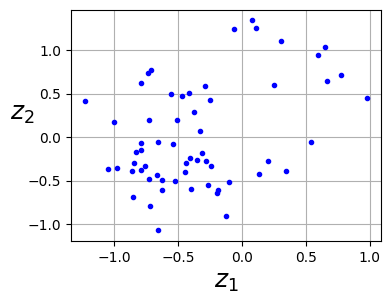

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True);

As you can see, the autoencoder found the best 2D plane to project the data onto, preserving as much variance in the data as it could (just like PCA).
Note that we exchage the axis in this figure, since autoencoder will not order the data according to the eigenvalues.

In [8]:
pca = PCA(n_components=2)
codings2 = pca.fit_transform(X_train)

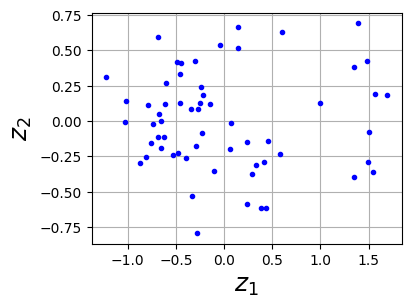

In [9]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings2[:,0], -codings2[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.grid(True);

## Stacked Autoencoders

Let's load the fashion MNIST dataset, scale it, and split it into a training set, a validation set, and a test set:

In [10]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

### MLP Layer

You can implement a stacked autoencoder very much like a regular deep MLP. The following code builds a stacked autoencoder for Fashion MNIST. we split the autoencoder model into two submodels: the encoder and the decoder.

* The encoder takes 28 × 28–pixel grayscale images, flattens them so that each image is represented as a vector of size 784, then processes these vectors through two `Dense` layers of diminishing sizes (100 units then 30 units), both using the `ReLU` activation function. For each input image, the encoder outputs a vector of size 30.
* The decoder takes codings of size 30 (output by the encoder) and processes them through two Dense layers of increasing sizes (100 units then 784 units), and it reshapes the final vectors into 28 × 28 arrays so the decoder’s outputs have the same shape as the encoder’s inputs.

* When compiling the stacked autoencoder, we use MSE loss and `Nadam` optimization.

* We train the model using `X_train` as **both the inputs and the targets** (and similarly, we use `X_valid` as both the validation inputs and targets)


In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.Input(shape=[30]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
stacked_ae.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 30)                  │          81,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 28, 28)              │          82,284 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,814 (639.90 KB)

 Trainable params: 163,814 (639.90 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0348 - val_loss: 0.0181
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0174 - val_loss: 0.0164
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0160 - val_loss: 0.0156
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0145 - val_loss: 0.0146
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0139 - val_loss: 0.0141
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 12/20
1719/1719 ━━━━━━━

### Visualizing the Reconstructions

One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs: the differences should not be too significant. Let’s plot a few images from the validation set, as well as their reconstructions:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


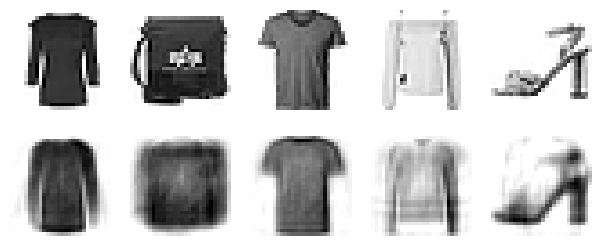

In [13]:
plot_reconstructions(stacked_ae, X_valid);

The reconstructions are recognizable, but a bit too lossy. We may need to train the model  for  longer,  or  make  the  encoder  and  decoder  deeper,  or  make  the  codings larger.  But  if  we  make  the  network  too  powerful,  it  will  manage  to  make  perfect reconstructions without having learned any useful patterns in the data. For now, let’s go with this model.

### Visualizing Fashion MNIST

Now that we have trained a stacked autoencoder, we can use it to reduce the dataset’s dimensionality. For visualization, this does not give great results compared to other dimensionality reduction algorithms, but one big advantage of autoencoders is that they can handle large datasets, with many instances and many features.

📌 **So one strategy is to use an autoencoder to reduce the dimensionality down to a reasonable level, then use another dimensionality reduction algorithm for visualization**. Let’s use this strategy to visualize Fashion MNIST. First, we use the encoder from our stacked autoencoder to reduce the dimensionality down to 30, then we use Scikit-Learn’s implementation of the t-SNE algorithm to reduce the dimensionality down to 2 for visualization:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(5000, 30)


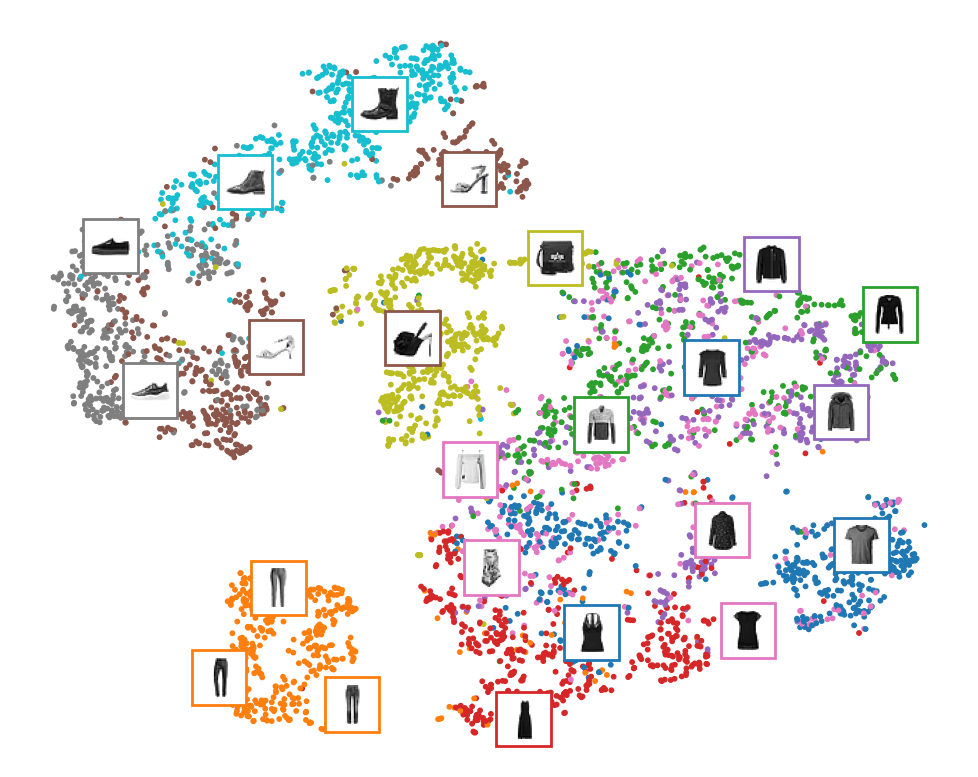

In [15]:
Z = stacked_encoder.predict(X_valid)
print(Z.shape)
plot_embeddings_tsne(X_valid, y_valid, Z)
plt.tight_layout();

The t-SNE algorithm identified several clusters which match the classes reasonably well (each class is represented with a different color).

### Using Convolutional Layers Instead of Dense Layers

If you are dealing with images, then the autoencoders we have seen so far will not work well (unless the images are very small): convolutional neural networks are far better suited than dense networks to work with images. So if you want to build an autoencoder for images, you will need to build a convolutional autoencoder. **The encoder is a regular CNN composed of convolutional layers and pooling layers.** It typically reduces the spatial dimensionality of the inputs (i.e., height and width) while increasing the depth (i.e., the number of feature maps). **The decoder must do the reverse (upscale the image and reduce its depth back to the original dimensions), and for this you can use transpose convolutional layers** (alternatively, you could combine upsampling layers with convolutional layers).

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

conv_encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[28, 28]),
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="relu",
                                 input_shape=[3, 3, 64]),
    tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="relu"),
    tf.keras.layers.Reshape([28, 28])
])

conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="mse", optimizer="nadam")
conv_ae.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 3, 3, 64)            │          23,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 28, 28)              │          23,233 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,529 (181.75 KB)

 Trainable params: 46,529 (181.75 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0314 - val_loss: 0.0113
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0106 - val_loss: 0.0113
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0089 - val_loss: 0.0105
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079 - val_loss: 0.0085
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0056 - val_loss: 0.0057


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


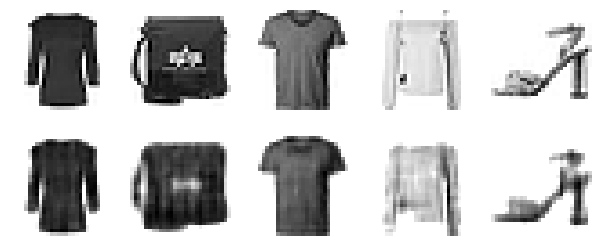

In [18]:
plot_reconstructions(conv_ae, X_valid)
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


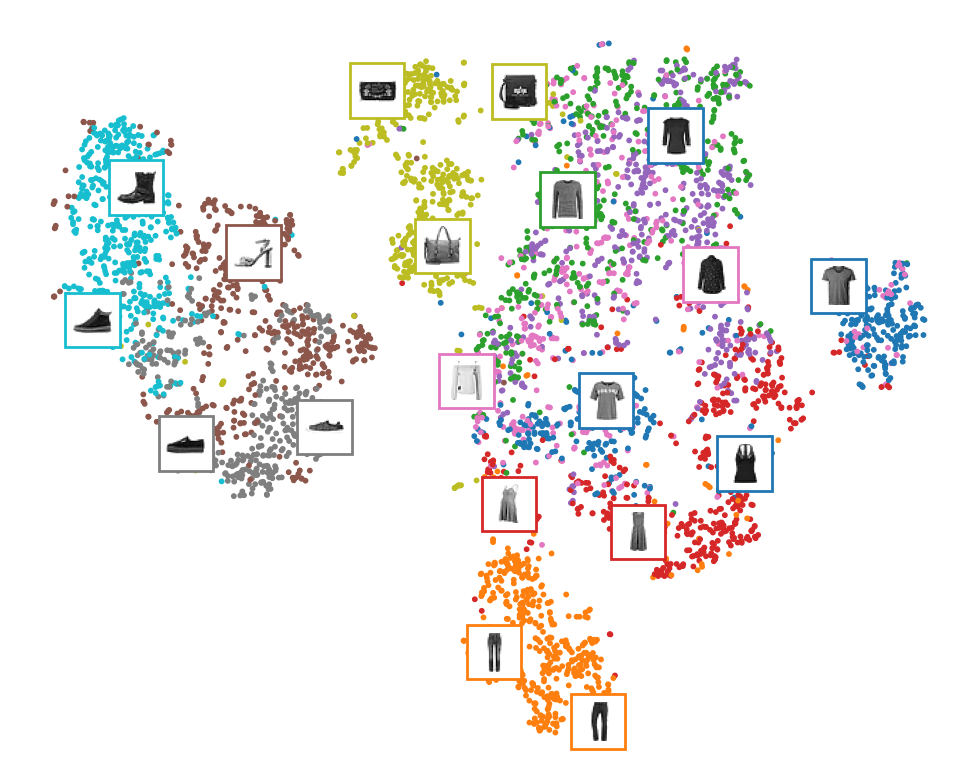

In [19]:
Z = conv_encoder.predict(X_valid)
N = Z.shape[0]
ZZ = np.reshape(Z, (N,-1))
plot_embeddings_tsne(X_valid, y_valid, ZZ)
plt.tight_layout();

## Stacked denoising Autoencoder

Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched-off inputs, just like in dropout (Bernoulli)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

# If you want, you can try replacing the Dropout layer with tf.keras.layers.GaussianNoise(0.2)
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[30]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer="nadam")
dropout_ae.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 30)                  │          81,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 28, 28)              │          82,284 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,814 (639.90 KB)

 Trainable params: 163,814 (639.90 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0401 - val_loss: 0.0215
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0225 - val_loss: 0.0199
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0212 - val_loss: 0.0190
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0205 - val_loss: 0.0186
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0200 - val_loss: 0.0181
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0196 - val_loss: 0.0178
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0194 - val_loss: 0.0177
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0189 - val_loss: 0.0172
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0188 - val_loss: 0.0172


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


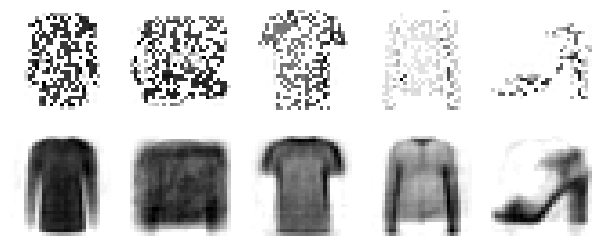

In [ ]:
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
plt.show()

## 🔍 Sparse Autoencoder

Another kind of constraint that often leads to good feature extraction is sparsity: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. For
example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations. As a result,
each neuron in the coding layer typically ends up representing a useful feature.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
# Normal autoencoder

stacked_encoder = tf.keras.Sequential([
    tf.keras.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.Input(shape=[300]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
stacked_ae.summary()
history = stacked_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 300)                 │         108,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 28, 28)              │         109,284 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,084 (851.89 KB)

 Trainable params: 218,084 (851.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0314 - val_loss: 0.0140
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0130 - val_loss: 0.0117
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0102 - val_loss: 0.0107
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0100 - val_loss: 0.0106
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0099 - val_loss: 0.0105
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0098 - val_loss: 0.0100
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0098 - val_loss: 0.0103


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


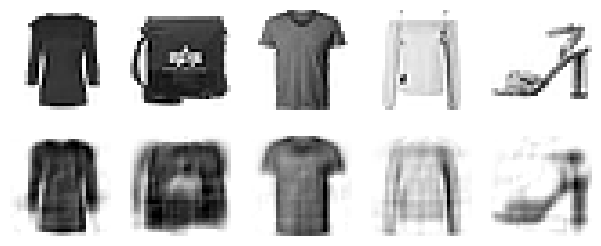

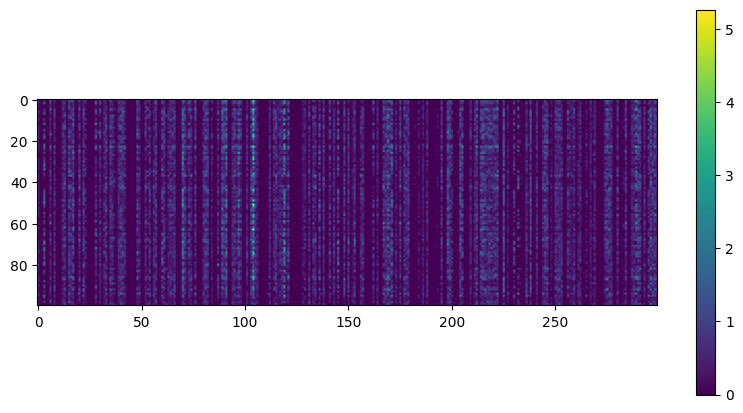

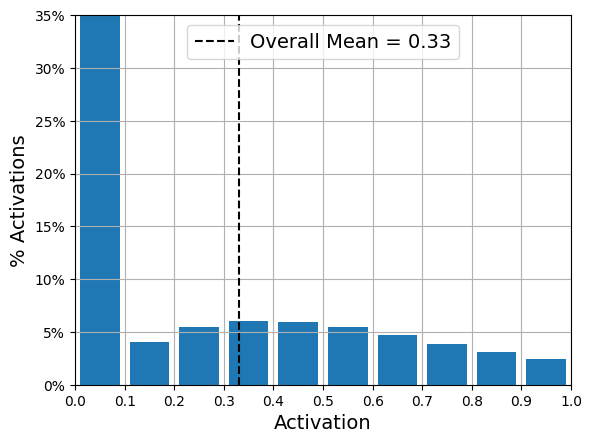

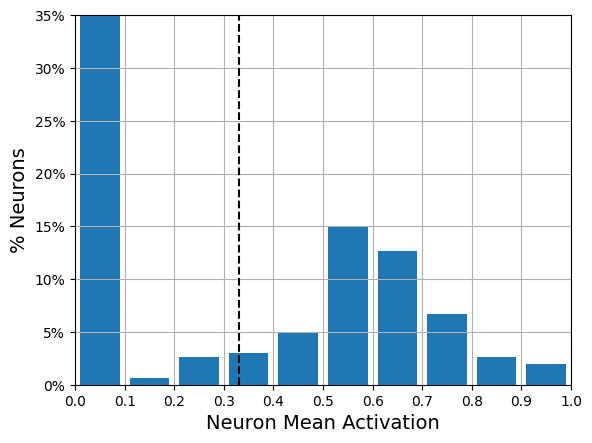

In [ ]:
plot_reconstructions(stacked_ae, X_valid)
plot_activations_heatmap(stacked_encoder)
plot_activations_histogram2(stacked_encoder, height=0.35);

Three figures show neuron activity (in the bottleneck layer) for an autoencoder applied to Fashion MNIST. Heatmap of 300 neuron activations (columns) across 100 examples (rows). Histogram of activation levels derived from this heatmap.
Histogram of the mean activation per neuron, averaged over all examples in the validation set. You can see that some neurons fire almost all the time (right side of the histogram).

A simple approach is to use the sigmoid activation function in the coding layer (to constrain the codings to values between 0 and 1), use a large coding layer (e.g., with 300 units), and add some L1 regularization to the coding layer’s activations.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

# extra code – compiles and fits the model
sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0802 - val_loss: 0.0309
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0295 - val_loss: 0.0269
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0261 - val_loss: 0.0249
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0243 - val_loss: 0.0236
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0229 - val_loss: 0.0224
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0218 - val_loss: 0.0215
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0210 - val_loss: 0.0207
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0204 - val_loss: 0.0201
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0199 - val_loss: 0.0197
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0195 - val_loss: 0.0193


This  `ActivityRegularization`   layer  just  returns  its  inputs,  but  as  a  side  effect  it adds a training loss equal to the sum of the absolute values of its inputs. This only affects training. Equivalently, you could remove the  `ActivityRegularization`  layer and  set  `activity_regularizer=tf.keras.regularizers.l1(1e-4)`   in  the  previous layer.  This  penalty  will  encourage  the  neural  network  to  produce  codings  close  to 0, but since it will also be penalized if it does not reconstruct the inputs correctly, it will have to output at least a few nonzero values. Using the L1  norm rather than the  L2   norm  will  push  the  neural  network  to  preserve  the  most  important  codings while eliminating the ones that are not needed for the input image (rather than just reducing all codings).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


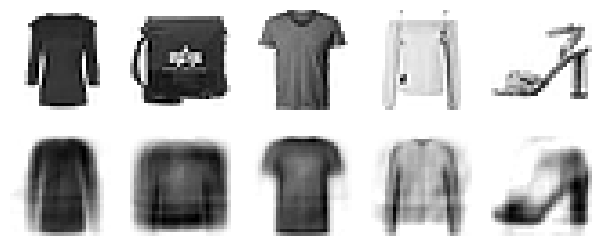

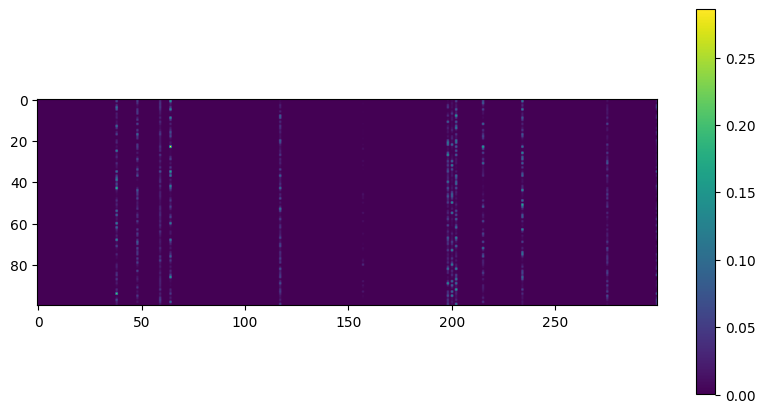

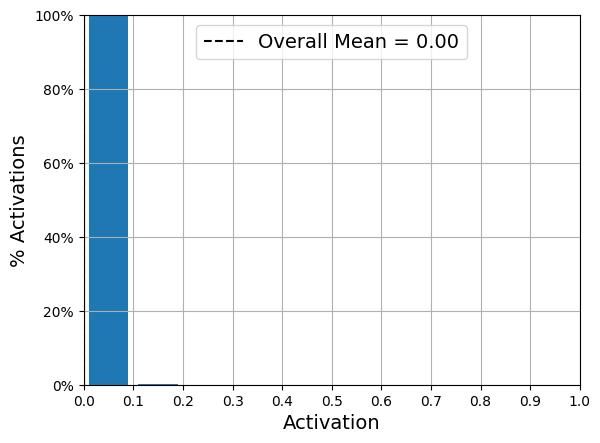

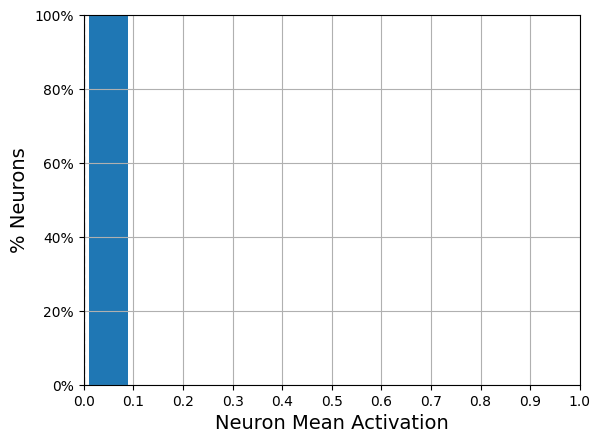

In [ ]:
plot_reconstructions(sparse_l1_ae, X_valid)
plot_activations_heatmap(sparse_l1_encoder)
plot_activations_histogram2(sparse_l1_encoder);

Another approach, which often yields better results, is to measure the actual sparsity of the coding layer at each training iteration, **and penalize the model when the measured sparsity differs from a target sparsity**. We do so by computing the average activation of each neuron in the coding layer, over the whole training batch. Once we have the mean activation per neuron, we want to penalize the neurons that are too active, or not active enough, by adding a sparsity loss to the cost function.

Once we have computed the sparsity loss for each neuron in the coding layer, we sum up these losses and add the result to the cost function. In order to control the relative importance of the sparsity loss and the reconstruction
loss, we can multiply the sparsity loss by a sparsity weight hyperparameter. If this weight is too high, the model will stick closely to the target sparsity, but it may not reconstruct the inputs properly, making the model useless. Conversely, if it is too low, the model will mostly ignore the sparsity objective and will not learn any interesting features.

We now have all we need to implement a sparse autoencoder based on the KL divergence. First, let’s create a custom regularizer to apply KL divergence regularization:

In [ ]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

Now let's use this regularizer to push the model to have about 10% sparsity in the coding layer:

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

# extra code – compiles and fits the model
sparse_kl_ae.compile(loss="mse", optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0706 - val_loss: 0.0226
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0202 - val_loss: 0.0193
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0162 - val_loss: 0.0175
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0140 - val_loss: 0.0144
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0125 - val_loss: 0.0132
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0116 - val_loss: 0.0119
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0110 - val_loss: 0.0111
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0105 - val_loss: 0.0114
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0100 - val_loss: 0.0102


1/1 [==============================] - 0s 110ms/step


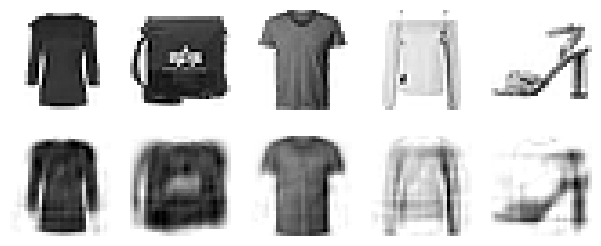

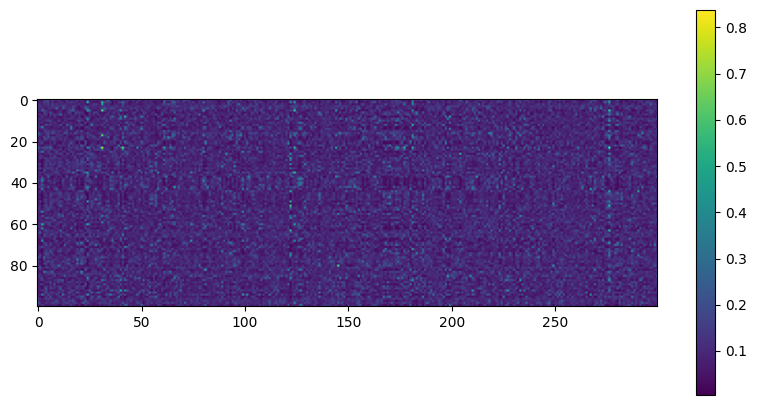

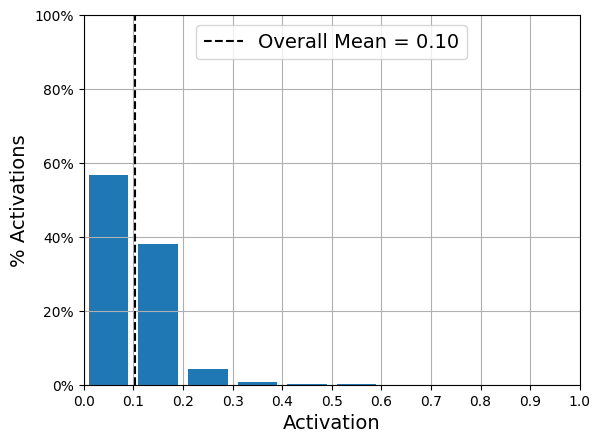

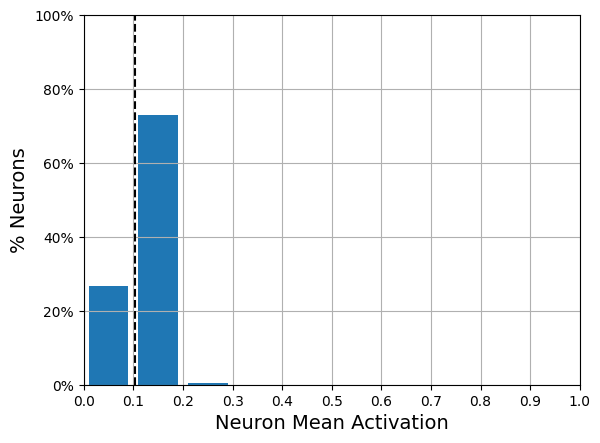

In [ ]:
plot_reconstructions(sparse_kl_ae, X_valid)
plot_activations_heatmap(sparse_kl_encoder)
plot_activations_histogram2(sparse_kl_encoder);

After training this sparse autoencoder on Fashion MNIST, the activations of the neurons in the coding layer are mostly close to 0 (about 70% of all activations are lower than 0.1), and all neurons have a mean activation around 0.1 (about 80% of all neurons have a mean activation between 0.1 and 0.2)

# 📘  Variational Autoencoder

We’re going to be implementing a VAE that can generate MNIST digits. It’s going to have three parts:

* An encoder network that turns a real image into a mean and a variance in the
latent space
* A sampling layer that takes such a mean and variance, and uses them to sample a random point from the latent space
* A decoder network that turns points from the latent space back into images

## Latent-space-sampling layer

First, we will need a custom layer to sample the codings:

In [20]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = tf.keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.keras.ops.shape(z_mean)[0]
        dim = tf.keras.ops.shape(z_mean)[1]
        epsilon = tf.keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + tf.keras.ops.exp(0.5 * z_log_var) * epsilon

## VAE implementation

### VAE encoder

Next, we can create the encoder, using the functional API because the model is not entirely sequential:

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

latent_dim = 10

encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 10)             │            170 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 10)             │            170 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 10)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,348 (270.89 KB)

 Trainable params: 69,348 (270.89 KB)

 Non-trainable params: 0 (0.00 B)

Note  that  the  `Dense`   layers  that  output  `z_mean` ($\mu$)  and  `z_log_var` ($\gamma$) have  the  same  inputs  (i.e.,  the  outputs  of  the  second  `Dense`   layer).  We  then pass  both  `z_mean`   and  `z_log_var`   to  the  `Sampling`   layer.  Finally,  the `variational_encoder`  model has three outputs. **Only the  codings  are required, but we add  `z_mean`  and  `z_log_var`  as well, in case we want to inspect their values.**

### VAE decoder

Now let’s build the decoder:

In [22]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = tf.keras.layers.Reshape((7, 7, 64))(x)
x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │          34,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,177 (352.25 KB)

 Trainable params: 90,177 (352.25 KB)

 Non-trainable params: 0 (0.00 B)

For  this  decoder,  we  could  have  used  the  sequential  API  instead  of  the  functional API, since it is really just a simple stack of layers, virtually identical to many of the decoders we have built so far.

### VAE model

Finally, let’s build the variational autoencoder model:

In [23]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """
        Defines the forward pass through the VAE.
        """
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        """
        Custom training step for the VAE.
        """
        if isinstance(data, tuple):
            data = data[0]  # Ignore labels if present

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z, training=True)

            # Compute reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=[1, 2]
                )
            )

            # Compute KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            # Total loss
            total_loss = reconstruction_loss + kl_loss

        # Compute gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """
        Custom test/validation step for the VAE.
        """
        if isinstance(data, tuple):
            data = data[0]  # Ignore labels if present

        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z, training=False)

        # Compute reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction), axis=[1, 2]
            )
        )

        # Compute KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )

        # Total loss
        total_loss = reconstruction_loss + kl_loss

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Lastly, we must add the latent loss and the reconstruction loss:

In [24]:
# Instantiate the VAE
vae = VAE(encoder, decoder)

# Compile the VAE with an optimizer
vae.compile(optimizer=tf.keras.optimizers.Adam())
# Train the VAE with validation data.
X_train = np.expand_dims(X_train, axis=-1)  # Shape: (batch_size, 28, 28, 1)
X_valid = np.expand_dims(X_valid, axis=-1)      # Shape: (batch_size, 28, 28, 1)
vae.fit(
    X_train,
    epochs=25,
    batch_size=128,
    validation_data=(X_valid, None)  # Targets are None since VAE is unsupervised
)

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - kl_loss: 7.0857 - loss: 388.8672 - reconstruction_loss: 381.7815 - val_kl_loss: 10.7168 - val_loss: 299.7067 - val_reconstruction_loss: 288.9899
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 10.4822 - loss: 293.3118 - reconstruction_loss: 282.8296 - val_kl_loss: 9.8821 - val_loss: 287.0183 - val_reconstruction_loss: 277.1362
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 9.9301 - loss: 283.1170 - reconstruction_loss: 273.1870 - val_kl_loss: 9.5042 - val_loss: 281.1562 - val_reconstruction_loss: 271.6519
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 9.3805 - loss: 278.5556 - reconstruction_loss: 269.1750 - val_kl_loss: 9.0558 - val_loss: 277.6268 - val_reconstruction_loss: 268.5711
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 8.9447 - loss: 275.7831 - reconstruction_loss: 266.8384 - val_kl_loss: 8.6618 - val_loss: 275.4970 - val_reconstruction_loss: 266.8351
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


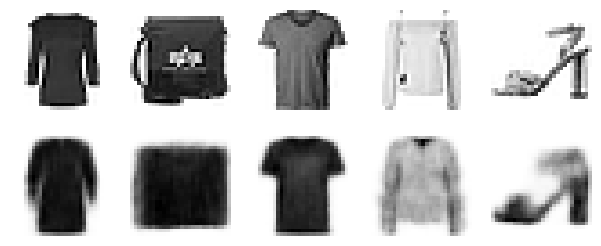

In [ ]:
plot_reconstructions(vae, X_valid);

## Generating Fashion MNIST Images

Now let’s use this variational autoencoder to generate images that look like fashion items. All we need to do is sample random codings from a Gaussian distribution and decode them:

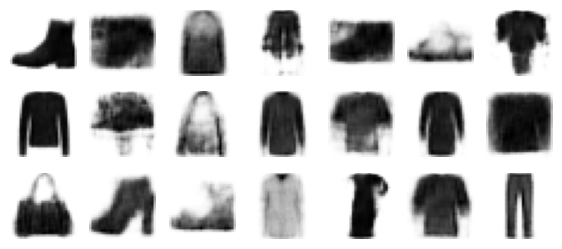

In [ ]:
codings = tf.random.normal(shape=[3 * 7, latent_dim])
images = decoder(codings).numpy()

plot_multiple_images(images, 7);

Variational autoencoders make it possible to perform semantic interpolation: instead of interpolating between two images at the pixel level, which would look as if the two images were just overlaid, we can interpolate at the codings level. For example, let’s take a few codings along an arbitrary line in latent space and decode them. We get a sequence of images that gradually go from sweaters to pants:

In [ ]:
codings = np.zeros([7, latent_dim])
codings[:, 2] = np.linspace(-0.8, 0.8, 7)  # axis 2 looks best in this case
images = decoder(codings).numpy()

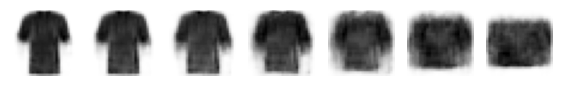

In [ ]:
plot_multiple_images(images);

# 🔍  Generative Adversarial Networks

See https://github.com/margaretmz/GANs-in-Art-and-Design/blob/main/2_dcgan_fashion_mnist.ipynb for more details.

See [stylegan](https://github.com/lucidrains/stylegan2-pytorch) if you are looking for state-of-the-art solutions.

# 🔍 Diffusion  Models

Starting with an image from the dataset, at each time step $t$, the diffusion process adds Gaussian noise with mean 0 and variance $\beta_t$. The model is then trained to reverse that process. More specifically, given a noisy image produced by the forward process, and given the time $t$, the model is trained to predict the total noise that was added to the original image, scaled to variance 1.

The [DDPM paper](https://arxiv.org/abs/2006.11239) increased $\beta_t$ from $\beta_1$ = 0.0001 to $\beta_T = $0.02 ($T$ is the max step), but the [Improved DDPM paper](https://arxiv.org/pdf/2102.09672.pdf) suggested using the following $\cos^2(\ldots)$ schedule instead, which gradually decreases $\bar{\alpha_t} = \prod_{i=0}^{t} \alpha_i$ from 1 to 0, where $\alpha_t = 1 - \beta_t$:

In [ ]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

np.random.seed(42)  # for reproducibility
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

In the DDPM paper, the authors used $T = 1,000$, while in the Improved DDPM, they bumped this up to $T = 4,000$, so we use this value. The variable `alpha` is a vector containing $\alpha_0, \alpha_1, ..., \alpha_T$. The variable `alpha_cumprod` is a vector containing $\bar{\alpha_0}, \bar{\alpha_1}, ..., \bar{\alpha_T}$.

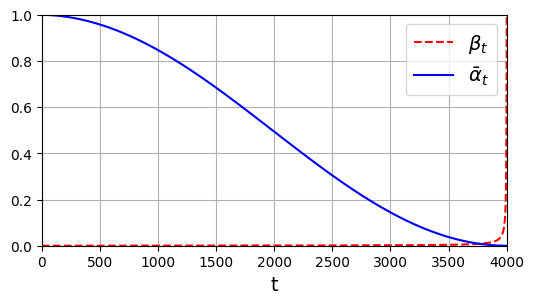

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(beta, "r--", label=r"$\beta_t$")
plt.plot(alpha_cumprod, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1])
plt.grid(True)
plt.xlabel(r"t")
plt.legend();

To train our model to reverse the diffusion process, **we will need noisy images from different time steps of the forward process.** For this, let’s create a  `prepare_batch()` function that will take a batch of clean images from the dataset and prepare them:

In [ ]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # scale from -1 to +1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

Let’s go through this code:
- For  simplicity  we  will  use  Fashion  MNIST,  so  the  function  must  first  add  a channel axis. It will also help to scale the pixel values from -1 to 1, so it’s closer to the final Gaussian distribution with mean 0 and variance 1.

- Next, the function creates `t`, a vector containing a random time step  for  each image in the batch, between `1` and `T`. Then it uses `tf.gather()` to get the value of  `alpha_cumprod`  for each of the time steps in the vector `t`. This gives us the vector  `alpha_cm`, containing one value of $\bar{\alpha_t}$  for each image.

- The next line reshapes the  `alpha_cm`  from `[batch size]` to `[batch size, 1, 1, 1]`. This is needed to ensure  `alpha_cm`  can be broadcasted with the batch  `X` . Then we generate some Gaussian noise with mean 0 and variance 1.

- Lastly, we use apply the diffusion process to the images. Note that  `x  **  0.5`   is  equal  to  the  square  root  of  `x`.  The  function  returns  a  tuple containing  the  inputs  and  the  targets.  **The  inputs  are  represented  as  a  Python `dict`  containing the noisy images and the time steps used to generate them. The targets are the Gaussian noise used to generate each image.**

Next,  we’ll  create  a  training  dataset  and  a  validation  set  that  will  apply  the `prepare_batch()`  function to every batch. As earlier,  `X_train`  and  `X_valid`  contain the Fashion MNIST images with pixel values ranging from 0 to 1:

In [ ]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

tf.random.set_seed(43)  # ensures reproducibility on CPU
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

As a quick sanity check, let's take a look at a few training samples, along with the corresponding noise to predict, and the original images (which we get by subtracting the appropriately scaled noise from the appropriately scaled noisy image):

Original images


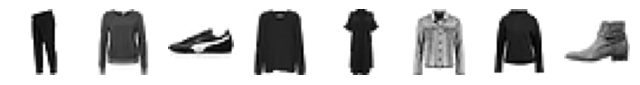

Time steps: [3405  312 3441 1991 2443 1657 3308 1151]
Noisy images


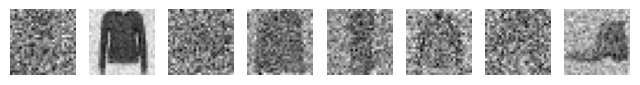

Noise to predict


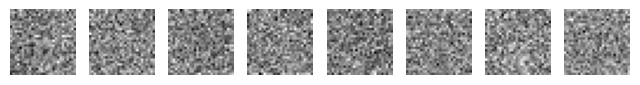

In [ ]:
# Just a quick sanity check

def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("Original images")
plot_multiple_images(X_original[:8].numpy())
plt.show()
print("Time steps:", X_dict["time"].numpy()[:8])
print("Noisy images")
plot_multiple_images(X_dict["X_noisy"][:8].numpy())
plt.show()
print("Noise to predict")
plot_multiple_images(Y_noise[:8].numpy())

Now we're ready to build the diffusion model itself. **It will need to process both images and times.** We will encode the times using a sinusoidal encoding, as suggested in the DDPM paper, just like in the [Attention is all you need](https://arxiv.org/abs/1706.03762) paper. Given a vector of _m_ integers representing time indices (integers), the layer returns an _m_ × _d_ matrix, where _d_ is the chosen embedding size.

In [ ]:
# Implements a custom time encoding layer

embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

Now let's build the model. In the Improved DDPM paper, they use a UNet model. We'll create a UNet-like model, that processes the image through `Conv2D` + `BatchNormalization` layers and skip connections, gradually downsampling the image (using `MaxPooling` layers with `strides=2`), then growing it back again (using `Upsampling2D` layers). Skip connections are also added across the downsampling part and the upsampling part. We also add the time encodings to the output of each block, after passing them through a `Dense` layer to resize them to the right dimension.

* **Note**: an image's time encoding is added to every pixel in the image, along the last axis (channels). So the number of units in the `Conv2D` layer must correspond to the embedding size, and we must reshape the `time_enc` tensor to add the width and height dimensions.
* This UNet implementation was inspired by keras.io's [image segmentation example](https://keras.io/examples/vision/oxford_pets_image_segmentation/), as well as from the [official diffusion models implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py). Compared to the first implementation, I added a few things, especially time encodings and skip connections across down/up parts. Compared to the second implementation, I removed a few things, especially the attention layers. It seemed like overkill for Fashion MNIST, but feel free to add them.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)  # adapt time encoding
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # add time data to every pixel

    skip = Z
    cross_skips = []  # skip connections across the down & up parts of the UNet

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2,
                                           padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

In [ ]:
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ X_noisy (InputLayer)      │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time (InputLayer)         │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 34, 34, 1)      │              0 │ X_noisy[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_encoding             │ (None, 64)             │              0 │ time[0][0]             │
│ (TimeEncoding)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 16)     │            160 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │          1,040 │ time_encoding[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 16)     │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 1, 1, 16)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 16)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 16)     │              0 │ get_item[0][0],        │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 16)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 32, 32, 32)     │            688 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 32)     │            128 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 32, 32, 32)     │          1,344 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 32)     │            128 │ separable_conv2d_1[0]… │
│ (BatchNormalization) 

 Total params: 280,369 (1.07 MB)

 Trainable params: 278,993 (1.06 MB)

 Non-trainable params: 1,376 (5.38 KB)

In [ ]:
# adds a ModelCheckpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model.keras", save_best_only=True)

history = model.fit(train_set, validation_data=valid_set, epochs=100, callbacks=[checkpoint_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 59s 18ms/step - loss: 0.1709 - val_loss: 0.0729
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0672 - val_loss: 0.0567
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0560 - val_loss: 0.0554
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0506 - val_loss: 0.0489
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0479 - val_loss: 0.0487
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0461 - val_loss: 0.0451
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0451 - val_loss: 0.0454
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0442 - val_loss: 0.0435
Epoch 9/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0437 - val_loss: 0.0448
Epoch 10/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0429 - val_loss: 0.0419
Epoch 11/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0427 - val_loss: 0.0422
Epoch 1

Now that the model is trained, we can use it to generate new images. For this, we just generate Gaussian noise, and pretend this is the result of the diffusion process, and we're at time $T$. Then we use the model to predict the image at time $T - 1$, then we call it again to get $T - 2$, and so on, removing a bit of noise at each step. At the end, we get an image that looks like it's from the Fashion MNIST dataset. The equation for this reverse process is at the top of page 4 in the DDPM paper (step 4 in algorithm 2).

In [ ]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # show progress
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

X_gen = generate(model)  # generated images

t = 1 

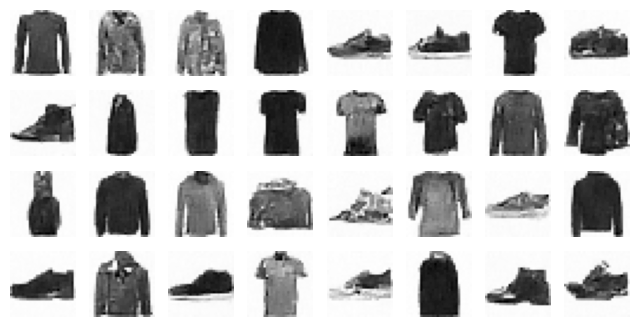

In [ ]:
plot_multiple_images(X_gen.numpy(), 8)

There is no shortcut in the reverse process. **This  may  take  a  minute  or  two.  That’s  the  main  drawback  of  diffusion  models: generating images is slow since the model needs to be called many times.** It’s possible to make this faster by using a smaller `T` value, or by using the same model prediction
for several steps at a time, but the resulting images may not look as nice. That said, despite this speed limitation, diffusion models do produce high-quality and diverse images

# 📘 Stable Diffusion with `diffuser`

📌 Note that diffuser currently only support `Pytorch` and `Flax`.

## Delve into stable diffusion

Stable Diffusion is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752). General diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*. For a more detailed overview of how they work, check [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.**

There are three main components in latent diffusion.

1. An autoencoder (VAE): The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model. The decoder, conversely, transforms the latent representation back into an image. During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder.

2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq): The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation. To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder. **Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers.**

3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel): The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings. Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

<p align="center">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>
<div align="center"> source: https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png </div>


The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm ($\alpha_t$ or $\beta_t$). Many different scheduler algorithms can be used for this computation, each having its pros and cons.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations. Once complete, the latent image representation is decoded by the decoder part of the VAE.

## Write your own inference pipeline with `diffusers`

Let's go through the `StableDiffusionPipeline` step by step to see how we could have written it ourselves. We will start by loading the individual models involved.

The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained()`.

In [50]:
from google.colab import userdata
from huggingface_hub import login
token = userdata.get('HF_TOKEN')
login(token=token)

In [51]:
# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

### VAE configuration

In [52]:
vae.config

FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 4),
            ('norm_num_groups', 32),
            ('sample_size', 512),
            ('scaling_factor', 0.18215),
            ('shift_factor', None),
            ('latents_mean', None),
            ('latents_std', None),
            ('force_upcast', True),
            ('use_quant_conv', True),
            ('use_post_quant_conv', True),
            ('mid_block_add_attention', True),
            ('_use_default_values',
     

In [53]:
summary(vae, (1, 3, 512, 512))

Layer (type:depth-idx)                             Output Shape              Param #
AutoencoderKL                                      [1, 3, 512, 512]          --
├─Encoder: 1-1                                     [1, 8, 64, 64]            33,421,064
│    └─Conv2d: 2-1                                 [1, 128, 512, 512]        3,584
│    └─ModuleList: 2-34                            --                        (recursive)
│    │    └─DownEncoderBlock2D: 3-1                [1, 128, 256, 256]        738,944
├─Decoder: 1-40                                    --                        (recursive)
│    └─UNetMidBlock2D: 2-96                        --                        (recursive)
│    │    └─ModuleList: 3-101                      --                        (recursive)
├─Encoder: 1-41                                    --                        (recursive)
│    └─ModuleList: 2-34                            --                        (recursive)
│    │    └─DownEncoderBlock2D: 3-9          

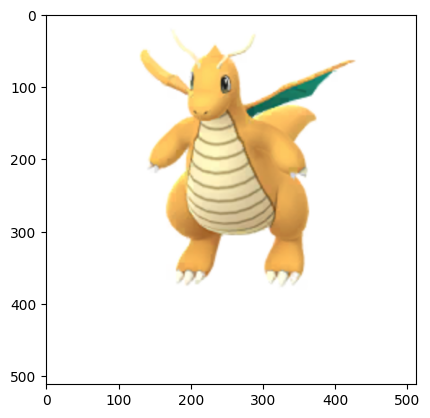

In [54]:
download_from_pokemondb('https://img.pokemondb.net/sprites/go/normal/dragonite.png','dragonite.png')
im = resize(rgba2rgb(imread('dragonite.png')), (512, 512)).astype(np.float32)
plt.imshow(im);

torch.Size([1, 4, 64, 64])


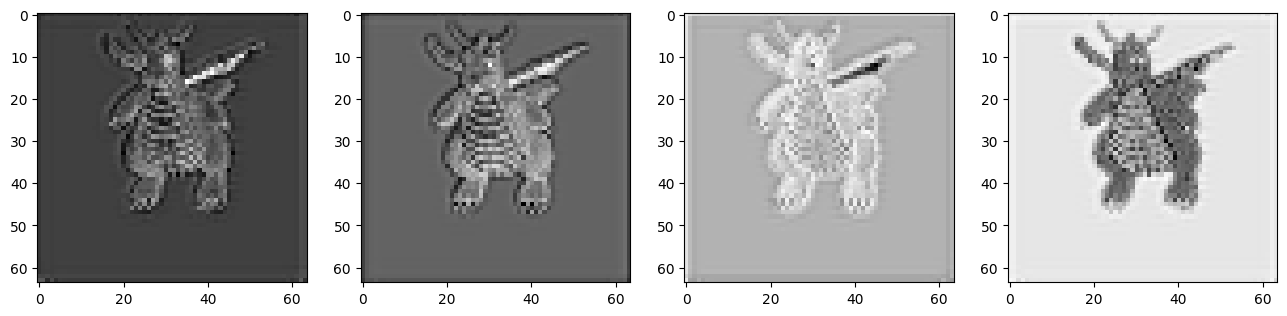

In [55]:
# Encode to the latent space
encoded = pil_to_latent(im)
print(encoded.shape)
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

📌 Notice that the order of Pytorch is `[batch, channel, height, width]`.

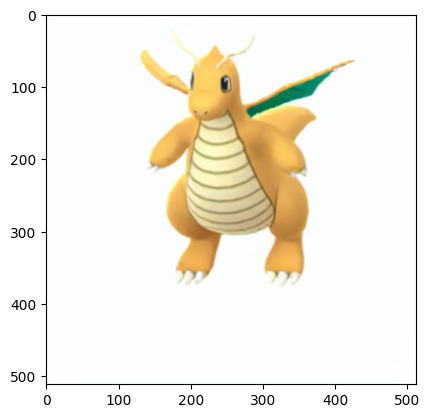

In [56]:
# Decode this latent representation back into an image
decoded = latents_to_pil(encoded)[0]
plt.imshow(decoded);

We start with a `3x512x512` image and it get compressed to a latent vector `4x64x64`. Each `3x8x8` pixel volume in the input image gets compressed down to just 4 numbers(`4x1x1`). This greatly speed up the task!

### UNet Configuration

In [57]:
unet.config

FrozenDict([('sample_size', 64),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('dropout', 0.0),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attenti

In [58]:
summary(unet, [(1, 4, 64, 64), (1,), (1, 77, 768)])

Layer (type:depth-idx)                                            Output Shape              Param #
UNet2DConditionModel                                              [1, 4, 64, 64]            --
├─Timesteps: 1-1                                                  [1, 320]                  --
├─TimestepEmbedding: 1-2                                          [1, 1280]                 1,639,680
│    └─Linear: 2-1                                                [1, 1280]                 410,880
├─SiLU: 1-3                                                       [1, 1280]                 --
├─TimestepEmbedding: 1-4                                          --                        (recursive)
│    └─Linear: 2-2                                                [1, 1280]                 1,639,680
├─Conv2d: 1-5                                                     [1, 320, 64, 64]          11,840
├─ModuleList: 1-54                                                --                        (recursive)
│   

### [Schedulers](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers)

Now instead of loading the pre-defined scheduler, we'll use the K-LMS scheduler instead.

In [59]:
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [60]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('use_karras_sigmas', False),
            ('use_exponential_sigmas', False),
            ('use_beta_sigmas', False),
            ('prediction_type', 'epsilon'),
            ('timestep_spacing', 'linspace'),
            ('steps_offset', 1),
            ('_use_default_values',
             ['timestep_spacing',
              'use_beta_sigmas',
              'prediction_type',
              'use_exponential_sigmas',
              'use_karras_sigmas']),
            ('_class_name', 'LMSDiscreteScheduler'),
            ('_diffusers_version', '0.7.0.dev0'),
            ('set_alpha_to_one', False),
            ('skip_prk_steps', True),
            ('clip_sample', False)])

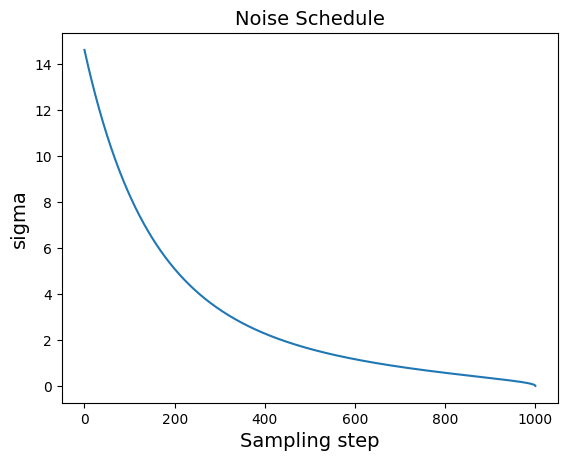

In [61]:
# Plotting this noise schedule:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

This 'sigma' is the amount of noise added to the latent representation.

## 🔍 Actual inference

Next we move the models to the GPU.

In [62]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

We now define the parameters we'll use to generate images.

In [63]:
prompt = ["photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 100            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

`guidance_scale` is a way to increase the adherence to the text as well as overall sample quality. In simple terms it force generation to better match with the prompt. Numbers like `7` or `8.5` give good results, if you use a very large number the images might look good, but will be less diverse.

### Text embedding

First, we get the `text_embeddings` for the prompt. These embeddings will be used to condition the UNet model.

In [64]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

We'll also get the unconditional text embeddings, which are just the embeddings for the padding token (empty text). They need to have the same shape as the conditional `text_embeddings` (`batch_size` and `seq_length`)

In [65]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [66]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings]) # Concatenate together

See [classifier-free guidence](https://betterprogramming.pub/diffusion-models-ddpms-ddims-and-classifier-free-guidance-e07b297b2869) for more detail.

### Diffusion models

Generate the intial random noise.

In [67]:
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

Next, we initialize the scheduler with our chosen `num_inference_steps`.
This will compute the `sigmas` (similar to $\alpha_t$) and exact time step values to be used during the denoising process.

In [68]:
scheduler.set_timesteps(num_inference_steps)

# The scheduler need to scale the latent
latents = latents * scheduler.init_noise_sigma
latents.shape

torch.Size([1, 4, 64, 64])

We are ready to write the denoising loop:

In [69]:
for i, t in enumerate(tqdm(scheduler.timesteps)):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2) # We have two samples here
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  # 3. optionally look at image
  if (i + 1) % 10 == 0:
      latents_viz = 1 / 0.18215 * latents
      with torch.no_grad():
        image = vae.decode(latents_viz).sample
      image = (image / 2 + 0.5).clamp(0, 1)
      image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
      images = (image * 255).round().astype("uint8")
      plt.imshow(images.squeeze())
      plt.axis("off")
      plt.show()
      del image, latents_viz

Output hidden; open in https://colab.research.google.com to view.

In [70]:
noise_pred_text = noise_pred.chunk(2)

In [71]:
noise_pred_text[0].shape

torch.Size([1, 4, 64, 64])

All schedulers provide one or multiple `step()` methods that can be used to compute the slightly less noisy image. The `step()` method may vary from one scheduler to another, but normally expects at least the model output, the `timestep` and the current `noisy_sample`.

### VAE

We now use the `vae` to decode the generated `latents` back into the image.

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")

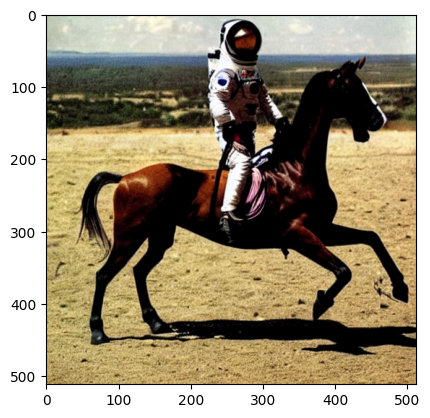

In [ ]:
plt.imshow(images.squeeze());

See [here](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb) and [here](https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb) for more in depth discussion. If you are interested in training, see [here](https://github.com/huggingface/diffusers/tree/main/examples).

## Stable diffusion with Pipeline of `difusser`

There are many built-in pipelines [available](https://github.com/huggingface/diffusers/tree/main/src/diffusers/pipelines).

`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code. First, we load the pre-trained weights of all components of the model. We use Stable Diffusion version 1.4 ([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)), but there are other variants that you may want to try:

* [stable-diffusion-v1-5/stable-diffusion-v1-5](https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5)

* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)

* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1). This version can produce images with a resolution of $768 \times 768$, while the others work at $512 \times 512$.

In addition to the model id [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), we're also passing a specific `revision` and `torch_dtype` to the `from_pretrained()` method.

We're loading the weights from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) and also tell `diffusers` to expect the weights in float16 precision by passing `torch_dtype=torch.float16`. If you want to ensure the highest possible precision, please make sure to remove `torch_dtype=torch.float16` at the cost of a higher memory usage.

In [72]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [73]:
pipe = pipe.to("cuda") # let's move the pipeline to GPU to have faster inference.
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

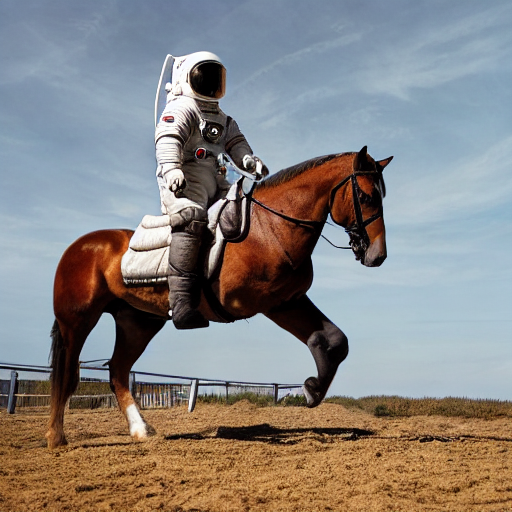

In [74]:
prompt = "photograph of an astronaut riding a horse"
image = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# If you're in a google colab you can directly display it with
image

You can change the number of inference steps using the `num_inference_steps` argument. In general, results are better the more steps you use. If you want faster results you can use a smaller number. If you want deterministic output you can pass a random seed to the pipeline. Every time you use the same seed you'll have the same image result.

  0%|          | 0/35 [00:00<?, ?it/s]

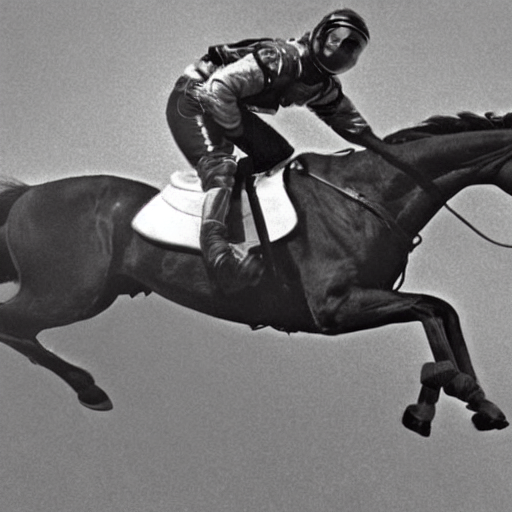

In [75]:
generator = torch.Generator("cuda").manual_seed(1024)
image = pipe(prompt, num_inference_steps=35, generator=generator).images[0]

image

To generate multiple images for the same prompt, we simply use a list with the same prompt repeated several times. We'll send the list to the pipeline instead of the string we used before.

In [76]:
num_images = 3
prompt = ["photograph of an astronaut riding a horse"] * num_images

images = pipe(prompt).images

  0%|          | 0/50 [00:00<?, ?it/s]

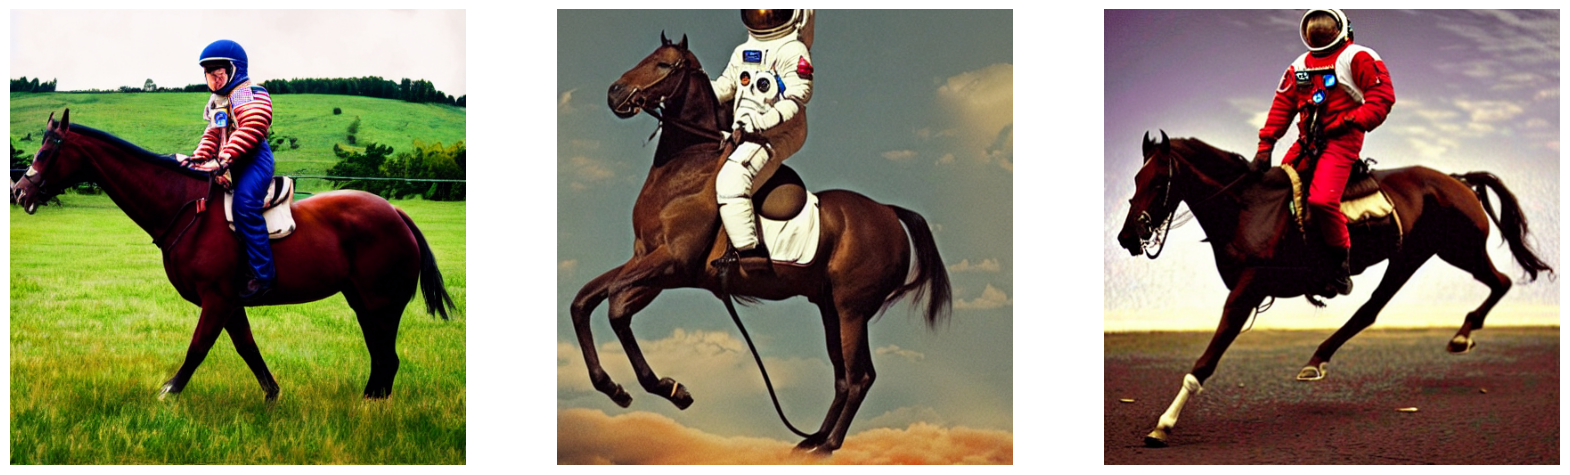

In [80]:
plot_images(images)

See [here](https://github.com/huggingface/diffusers/tree/main/examples) and [here](https://github.com/huggingface/notebooks/tree/main/diffusers) for more examples or training.

# 📘 High-performance image generation using Stable Diffusion in `KerasCV`

In [3]:
%pip install -Uq keras
%pip install -Uq git+https://github.com/keras-team/keras-hub.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


📌 Popular pretrained models are frequently becoming multi-modal. In the text domain, chat LLMs are adding support for image and audio inputs and outputs. In the vision domain, using text encoders is common for a wide range of tasks from image segmentation to image generation. To that end, we are consolidating KerasNLP and KerasCV into a KerasHub package. See https://github.com/keras-team/keras-hub/issues/1831.

Before diving into how latent diffusion models work, let's start by generating some images using KerasHub's APIs.

To avoid reinitializing variables for different tasks, we'll instantiate and load the trained backbone and preprocessor using KerasHub's `from_preset()` factory method. If you only want to perform one task at a time, you can use a simpler API like this:

```
text_to_image = keras_hub.models.StableDiffusion3TextToImage.from_preset(
    "stable_diffusion_3_medium", dtype="float16"
)
```

That will automatically load and configure trained backbone and preprocessor for you.

Note that in this guide, we'll use `height=512` and `width=512` for faster image generation. For higher-quality output, it's recommended to use the default size of 1024. Since the entire backbone has about 3 billion parameters, which can be challenging to fit into a consumer-level GPU, we set `dtype="float16"` to reduce the usage of GPU memory – the officially released weights are also in float16.

It is also worth noting that the preset "stable_diffusion_3_medium" excludes the T5XXL text encoder, as it requires significantly more GPU memory. The performace degradation is negligible in most cases. The weights, including T5XXL, will be available on KerasHub soon.

First, we construct a model:



In [1]:
# @title Restart kernel and Set different backend
import os

os.environ["KERAS_BACKEND"] = "jax"
import time
import keras
import keras_hub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def display_generated_images(images):
    """Helper function to display the images from the inputs.

    This function accepts the following input formats:
    - 3D numpy array.
    - 4D numpy array: concatenated horizontally.
    - List of 3D numpy arrays: concatenated horizontally.
    """
    display_image = None
    if isinstance(images, np.ndarray):
        if images.ndim == 3:
            display_image = Image.fromarray(images)
        elif images.ndim == 4:
            concated_images = np.concatenate(list(images), axis=1)
            display_image = Image.fromarray(concated_images)
    elif isinstance(images, list):
        concated_images = np.concatenate(images, axis=1)
        display_image = Image.fromarray(concated_images)

    if display_image is None:
        raise ValueError("Unsupported input format.")

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(display_image)
    plt.show()
    plt.close()

In [2]:
backbone = keras_hub.models.StableDiffusion3Backbone.from_preset(
    "stable_diffusion_3_medium", image_shape=(512, 512, 3), dtype="float16"
)
preprocessor = keras_hub.models.StableDiffusion3TextToImagePreprocessor.from_preset(
    "stable_diffusion_3_medium"
)
text_to_image = keras_hub.models.StableDiffusion3TextToImage(backbone, preprocessor)

100%|██████████| 3.07k/3.07k [00:00<00:00, 3.95MB/s]


100%|██████████| 5.57G/5.57G [05:53<00:00, 16.9MB/s]


100%|██████████| 4.08k/4.08k [00:00<00:00, 5.14MB/s]


100%|██████████| 976k/976k [00:01<00:00, 754kB/s]


100%|██████████| 512k/512k [00:01<00:00, 478kB/s]


100%|██████████| 976k/976k [00:01<00:00, 733kB/s]


100%|██████████| 512k/512k [00:01<00:00, 480kB/s]


Next, we give it a prompt:

In [3]:
prompt = "photograph of an astronaut riding a horse"
generated_image = text_to_image.generate(prompt)

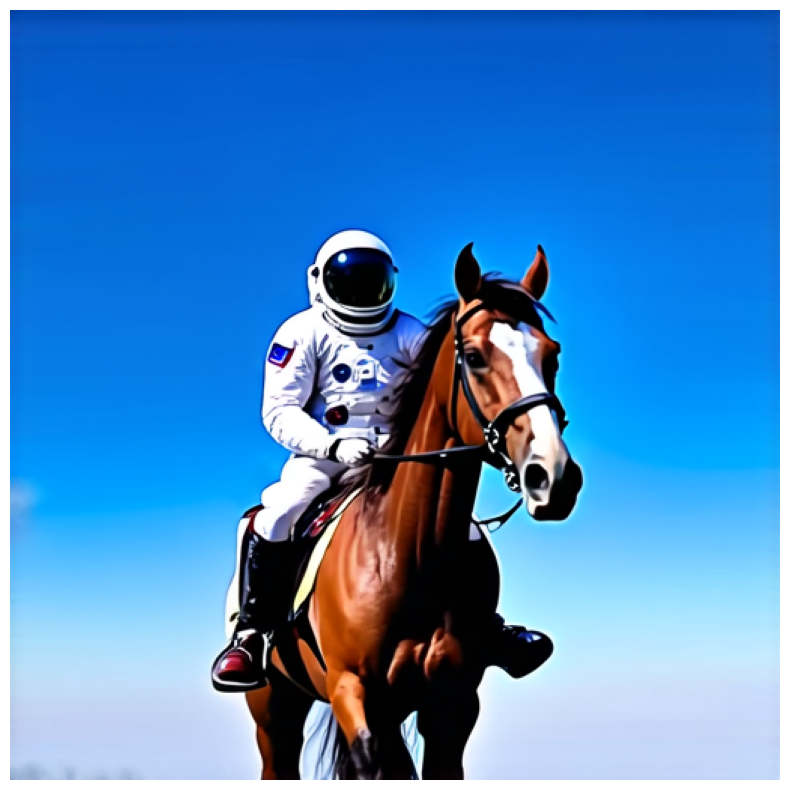

In [4]:
display_generated_images(generated_image)

> When using JAX or TensorFlow backends, you might experience a significant compilation time during the first `generate()` call. The subsequent `generate()` call speedup highlights the power of JIT compilation and caching in frameworks like JAX and TensorFlow, making them well-suited for high-performance deep learning tasks like image generation.

Now we know the basis of the Stable Diffusion 3 and the text-to-image task. Let's explore further using KerasHub APIs.

To use KerasHub's APIs for efficient batch processing, we can provide the model with a list of prompts:

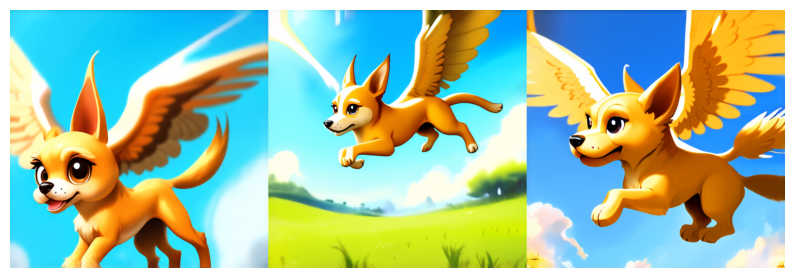

In [5]:
prompt = ("cute magical flying dog, fantasy art, "
    "golden color, high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting, mystery, adventure")
generated_images = text_to_image.generate([prompt] * 3)
display_generated_images(generated_images)

In [ ]:
text_to_image.generate?

## Perks of KerasCV

The `num_steps` parameter controls the number of denoising steps used during image generation. Increasing the number of steps typically leads to higher quality images at the expense of increased generation time. In Stable Diffusion 3, this parameter defaults to 28.

`guidance_scale` affects how much the "prompts" influences image generation. A lower value gives the model creativity to generate images that are more loosely related to the prompt. Higher values push the model to follow the prompt more closely. If this value is too high, you may observe some artifacts in the generated image. In Stable Diffusion 3, it defaults to 7.0.

Cost time (`num_steps=10`): 4.03s
Cost time (`num_steps=28`): 5.64s
Cost time (`num_steps=50`): 9.79s


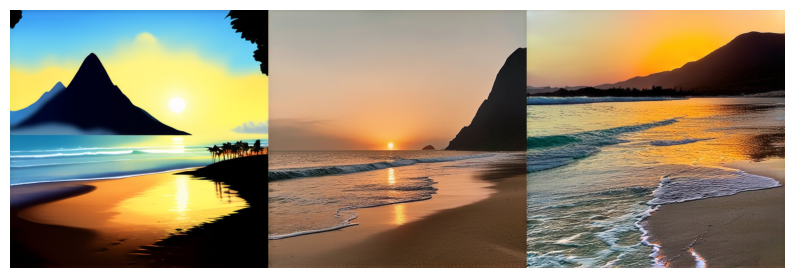

In [6]:
prompt = "Sunset on the beach and mountain"

num_steps = [10, 28, 50]
generated_images = []
for n in num_steps:
    st = time.time()
    generated_images.append(text_to_image.generate(prompt, num_steps=n))
    print(f"Cost time (`num_steps={n}`): {time.time() - st:.2f}s")

display_generated_images(generated_images)

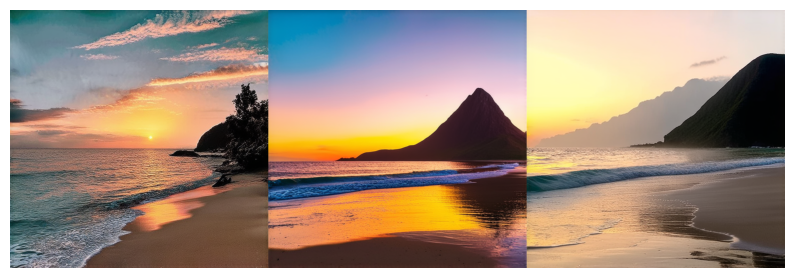

In [7]:
generated_images = [
    text_to_image.generate(prompt, guidance_scale=2.5),
    text_to_image.generate(prompt, guidance_scale=7.0),
    text_to_image.generate(prompt, guidance_scale=10.5),
]
display_generated_images(generated_images)

# 📘 References

1. [https://github.com/ageron/handson-ml3/](https://github.com/ageron/handson-ml3/)

2. [https://github.com/fchollet/deep-learning-with-python-notebooks](https://github.com/fchollet/deep-learning-with-python-notebooks)

3. [https://github.com/probml/pml-book/tree/main](https://github.com/probml/pml-book/tree/main)

4. [https://github.com/huggingface/notebooks/tree/main/diffusers](https://github.com/huggingface/notebooks/tree/main/diffusers)

5. [https://keras.io/guides/keras_hub/stable_diffusion_3_in_keras_hub/](https://keras.io/guides/keras_hub/stable_diffusion_3_in_keras_hub/)